##### Copyright 2021 Google LLC. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#**RLDS: Tutorial**
This colab provides an overview of how RLDS can be used to load and manipulate datasets.

If you're looking for more complex examples, see the the [RLDS examples Notebook](https://colab.research.google.com/github/google-research/rlds/blob/main/rlds/examples/rlds_examples.ipynb) in Google Colab. Or [this one](https://colab.research.google.com/github/google-research/rlds/blob/main/rlds/examples/rlds_performance.ipynb) for performance tips.


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a href="https://colab.research.google.com/github/google-research/rlds/blob/main/rlds/examples/rlds_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Run In Google Colab"/></a>
  </td>
</table>

##Install module

In [ ]:
!pip install rlds[tensorflow]
!pip install tfds-nightly

##Import Modules

In [1]:
from typing import Any, Dict, Union, NamedTuple

import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import rlds

##Load dataset
We can load an RLDS dataset using TFDS. See the available datasets in the [TFDS catalog](https://www.tensorflow.org/datasets/catalog/overview) and look for those with an episodic structure.

For example:
* [D4RL Datasets](https://www.tensorflow.org/datasets/catalog/overview#d4rl)
* [RL Unplugged Datasets](https://www.tensorflow.org/datasets/catalog/overview#rl_unplugged)
* [RLDS Datasets](https://www.tensorflow.org/datasets/catalog/overview#rlds)

In [2]:
dataset_name = 'd4rl_mujoco_walker2d'  # @param { isTemplate: true}
num_episodes_to_load = 10   # @param { isTemplate: true}

In [3]:
dataset = tfds.load(dataset_name, split = f'train[:{num_episodes_to_load}]')

The content of the dataset complies with the format described in the RLDS [README](https://github.com/google-research/rlds/blob/main/README.md): an outer `tf.data.Dataset` of episodes, each of them containing episode metadata and a `tf.data.Dataset` of steps.

For example, let's inspect the first episode of the dataset that we have just loaded.

In [ ]:
print(dataset.element_spec)

{'steps': DatasetSpec({'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))}


##Basic dataset transformations
RLDS datasets can be manipulated with `tf.data.Dataset` functions, but the RLDS library provides building blocks to perform more complex transformations that prepare the data to be consumed by an algorithm.

In the following sections, we show how to use some of the standard `tf.data` functions and some of the RLDS transformations.

If you are not familiar with the `tf.data.Dataset` API, we recommend you to
take a look first at the `tf.data` documentation [here](https://www.tensorflow.org/guide/data).  Methods such as `map`, `flat_map`, `batch` and `filter` are worth to know about. RLDS provides a number of helper functions built with the use of `tf.data` pipelines, but you will still need to use `tf.data` directly to glue them together.

See this [colab](https://colab.research.google.com/github/google-research/rlds/blob/main/rlds/examples/rlds_performance.ipynb) for performance tips when building `tf.data.Dataset` pipelines for RLDS datasets.


### `tf.data` operations
These are a couple of examples of how to use standard `tf.data` operations with RLDS datasets.


This first example, uses `take` and `skip` to skip one episode and to take the next 5. The result is a dataset of 5 episodes.

In [ ]:
shortened_dataset = dataset.skip(1).take(5)

This other example converts a dataset of episodes into a flat dataset of steps using `flat_map`.

The result, `steps_dataset`, is a sequence of all episodes' steps from the original dataset.

In [ ]:
dataset_steps = dataset.flat_map(lambda episode: episode[rlds.STEPS])

print(dataset_steps.element_spec)

{'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}


### Zeros like
RLDS offers functions to create empty steps with the same shape and dtype of the original step (and datasets that contain only one of these zeros-like steps).

In [ ]:
# Creates a step with all fields initialized to zeros.
zero_step = rlds.transformations.zeros_from_spec(
    dataset.element_spec[rlds.STEPS].element_spec)

# Creates an episode with steps and the episode metadata initialized to zeros.
zero_episode = rlds.build_episode(
    steps=rlds.transformations.zero_dataset_like(
        dataset.element_spec[rlds.STEPS]),
    metadata=rlds.transformations.zeros_from_spec({
        k: dataset.element_spec[k]
        for k in dataset.element_spec.keys()
        if k != rlds.STEPS
    }))

zero_episode

{'steps': <TensorDataset shapes: {action: (6,), discount: (), is_first: (), is_last: (), is_terminal: (), observation: (17,), reward: ()}, types: {action: tf.float32, discount: tf.float32, is_first: tf.bool, is_last: tf.bool, is_terminal: tf.bool, observation: tf.float32, reward: tf.float32}>}

###Alignment of the step fields
RLDS retrieves the steps with the current observation, the action applied to this observation, and the reward obtained after applying this action. However, algorithms may consume them with a different alignment. For example, an algorithm may need a step with the next observation instead of the current one. The RLDS library supports an alignment transformation to shift steps fields. Here is an example.
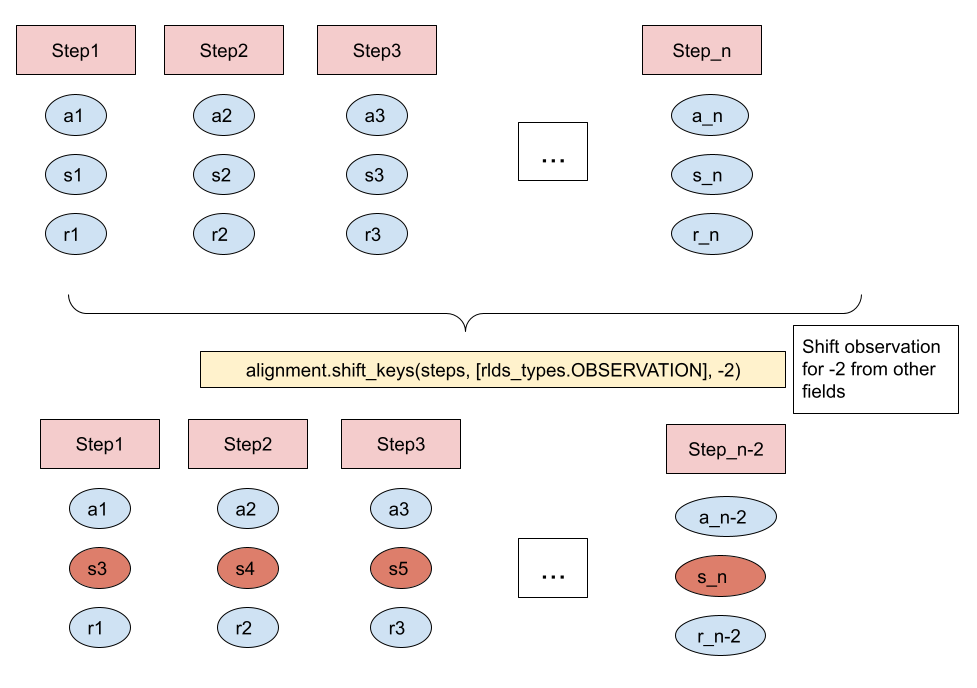

In [ ]:
# Uses `shift_keys` to shift observations 2 steps backwards in an episode.
def shift_episode(episode):
  episode[rlds.STEPS] = rlds.transformations.alignment.shift_keys(
      episode[rlds.STEPS], [rlds.OBSERVATION], -2)
  return episode

# Shifts observations 2 steps backwards in all episodes.
shifted_dataset = dataset.map(shift_episode)

###Conditional truncation
This operation allows truncating a dataset after a condition (that is defined by the user) has been met.

In [ ]:
# Defines a condition function.
def condition(step):
  return step[rlds.REWARD] > 5.

# Truncates dataset after the first step with a reward higher than 5.
truncated_dataset = dataset.map(
    lambda episode: rlds.transformations.truncate_after_condition(
        episode[rlds.STEPS], condition))

###Concatenate
The RLDS library provides a custom `concatenate` function that supports concatenating datasets even if the dataset elements do not contain the same fields. The only condition is that the elements of the datasets are dictionaries (like the steps or the episodes).

In this example, we just add a zeros-like step at the end of each episode.

In [ ]:
def concatenate_episode(episode):
  episode[rlds.STEPS] = rlds.transformations.concatenate(
      episode[rlds.STEPS],
      rlds.transformations.zero_dataset_like(
          dataset.element_spec[rlds.STEPS]))
  return episode

# Concatenates the existing dataset with a zeros-like dataset.
zero_concatenate_dataset = dataset.map(concatenate_episode)

When the elements of the two datasets don't contain the same fields, the new dataset contains the union of the fields and it adds the extra fields with a zero-like value.

For example, let's change the example above to indicate that the empty step we added is not a real step, but only padding. To do so, instead of concatenating a zeros-like step, we concatenate a dataset with one step that contains only the following: `{'is_padding'=True}`.

In the output dataset, all the real steps will contain the new key (`'is_padding'`) with a default value (`False`). The new last step will contain all the step keys with a zero value, and `'is_padding'=True`.

In [ ]:
def concatenate_episode(episode):
  step_with_padding = tf.data.Dataset.from_tensors({'is_padding': [True]})
  episode[rlds.STEPS] = rlds.transformations.concatenate(
      episode[rlds.STEPS], step_with_padding)
  return episode

# Adds field `is_padding` in the existing dataset.
zero_concatenate_dataset = dataset.map(concatenate_episode)

If we only want to pad episodes that end in a terminal state, we can use  `concat_if_terminal`.

In [ ]:
# Builds a dataset with a zeros-like step.
def make_extra_step(_):
  return rlds.transformations.zero_dataset_like(
      dataset.element_spec[rlds.STEPS])

def concatenate_episode(episode):
  episode[rlds.STEPS] = rlds.transformations.concat_if_terminal(
      episode[rlds.STEPS], make_extra_step)
  return episode

# Concatenates the existing dataset with a zeros-like dataset if the existing
# dataset ends with a terminal step.
condition_concatenate_dataset = dataset.map(concatenate_episode)

### Batch dataset with overlap
RLDS provides a flexible batching method that allows to configure batches as sliding windows, allowing, for example, to create batches that overlap.


In [ ]:
batch_size = 2
shift = 3
batched_dataset = rlds.transformations.batch(dataset, batch_size, shift)

##Statistics
The RLDS library includes optimized helpers to calculate statistics across the dataset. To avoid making assumptions on the data, many of them receive as an extra parameter a function to select the data of the step that we want to use in the stats.

###Sum of step fields

`sum_nested_steps` allows users to sum data accross all the steps in the dataset. It gets an extra parameter, `get_data`, that enables the user to define which data of the step is going to be added. In this example, we take the action and reward of all steps.

In [ ]:
@tf.function
def get_data(step):
  # Extracts reward and action from the step (sets them to zeros if this is the
  # last step).
  if step[rlds.IS_LAST]:
    return {k: tf.nest.map_structure(tf.zeros_like, step[k]) for k in [rlds.REWARD, rlds.ACTION]}
  else:
    return {k: step[k] for k in [rlds.REWARD, rlds.ACTION]}

# Calculates sum across reward and action fields.
sum = rlds.transformations.sum_nested_steps(dataset, get_data)

print('sum rewards: ', sum[rlds.REWARD].numpy())
print('sum actions: ', sum[rlds.ACTION].numpy())

sum rewards:  31433.799
sum actions:  [2541.966   1973.7347  1183.858   3343.9478  1234.8883   438.08795]


### Total reward per episode

`sum_dataset` can be used to efficiently sum the values of one or multiple fields of a step. For example, to calculate the total reward per episode.

In [16]:
@tf.function
def data_to_sum(step):
  # This assumes that the reward is valid in all steps.
  return step[rlds.REWARD]
 

@tf.function
def add_total_reward(episode):
  total = rlds.transformations.sum_dataset(episode[rlds.STEPS], data_to_sum)
  return {
      **episode,
      'total_reward': total
  }

ds_with_total_reward  = dataset.map(add_total_reward)

for e in ds_with_total_reward:
  print(e['total_reward'])

tf.Tensor(2893.3196, shape=(), dtype=float32)
tf.Tensor(4872.342, shape=(), dtype=float32)
tf.Tensor(213.88623, shape=(), dtype=float32)
tf.Tensor(4916.548, shape=(), dtype=float32)
tf.Tensor(302.69305, shape=(), dtype=float32)
tf.Tensor(4875.001, shape=(), dtype=float32)
tf.Tensor(2630.2253, shape=(), dtype=float32)
tf.Tensor(5102.949, shape=(), dtype=float32)
tf.Tensor(643.4336, shape=(), dtype=float32)
tf.Tensor(5012.339, shape=(), dtype=float32)


###Episode length

`episode_length` computes the number of steps in a given dataset.

In [ ]:
# Calculates lengths for each episode.
lengths = dataset.map(
    lambda episode: rlds.transformations.episode_length(episode[rlds.STEPS]))

### Mean and std

`mean_and_std` computes the mean and standard deviation accross all the steps for any field (or nested field) of the step.

Besides the dataset, users need to provide a function `get_data` that returns
two values:

* the data in this step (for example one of the fields of the step)
* if the data is valid (for example, in the last step in SAR alignment, the action and the reward are usually undefined).

When the data in the observation and action is numeric, and the user hasn't changed the alignment, it is possible to use a predefined `get_data`: `sar_fields_mask`, as in the following example (note that it may not work with all the datasets).

In [ ]:
# Calculates mean and std of reward, observation and action across the full dataset of episodes.
mean, std = rlds.transformations.mean_and_std(dataset, rlds.transformations.sar_fields_mask)
print('mean[REWARD]: ', mean[rlds.REWARD].numpy())
print('std[REWARD]:' , std[rlds.REWARD])

print('mean[OBSERVATION]: ', mean[rlds.OBSERVATION].numpy())
print('std[OBSERVATION]:' , std[rlds.OBSERVATION])

print('mean[ACTION]: ', mean[rlds.ACTION].numpy())
print('std[ACTION]:' , std[rlds.ACTION])

mean[REWARD]:  4.841182631776529
std[REWARD]: 1.391955884612761
mean[OBSERVATION]:  [ 1.05274827  0.04893328 -0.47156038 -1.0142821   0.3008562  -0.49524645
 -0.84853085  0.13825982  3.83863968 -0.07165551 -0.09909935 -0.18603987
 -0.27781131 -0.02443931 -0.45444301 -0.65726478 -0.19884101]
std[OBSERVATION]: [0.11461395 0.37376662 0.58621069 0.91406946 0.74730198 0.67789405
 0.7619462  0.72785354 1.40508326 1.08847192 5.1517826  5.55214327
 6.91617172 6.2763008  5.90013166 6.99249852 6.11710722]
mean[ACTION]:  [0.39149331 0.30397886 0.18232836 0.51500812 0.19018763 0.06747081]
std[ACTION]: [0.61771837 0.62655076 0.72291193 0.59590623 0.62789729 0.73598925]


To customize this function (for example, when we change the alignment, or when we want only the stats of certain fields), we can provide our own implementation of `get_data`.

In [ ]:
def get_data(step):
  # Obtains the desired data from the step.
  data = {rlds.REWARD: step[rlds.REWARD]}
  # Discards the data of the last step.
  if step[rlds.IS_LAST]:
    mask = {
        rlds.REWARD: False,
    }
  else:
    mask = {
        rlds.REWARD: True,
    }
  return data, mask

# Calculates mean and std of the reward across the full dataset of episodes.
mean, std = rlds.transformations.mean_and_std(dataset, get_data)
print('mean: ', mean[rlds.REWARD].numpy())
print('std:' , std[rlds.REWARD])

mean:  4.841182631776529
std: 1.391955884612761


##RL examples
This section includes examples of more complex operations based on the RLDS library.

### Filter episodes based on average reward

In this example, we fist add the average reward to each episode, and then filter out episodes with an average reward higher than 5.

In [ ]:
# Defines a function to calculate mean of rewards per episode.
def reduction_fn(episode):
  @tf.function
  def data_to_sum(step):
    # Sets the reward of the last step to 0
    if step[rlds.IS_LAST]:
      return {rlds.REWARD: tf.zeros_like(step[rlds.REWARD])}
    else:
      return {rlds.REWARD: step[rlds.REWARD]}

  total_reward = rlds.transformations.nested_ops.sum_dataset(
      episode[rlds.STEPS], data_to_sum)
  count = rlds.transformations.episode_length(episode[rlds.STEPS])
  avg = tf.cast(total_reward[rlds.REWARD], tf.float32) / (tf.cast(
      count, tf.float32)-1)
  episode['avg_reward'] = avg
  return episode

# Calculates average reward per episode.
dataset_with_avg_reward = dataset.map(reduction_fn)
print('mean rewards: ', list(dataset_with_avg_reward.map(lambda e: e['avg_reward']).as_numpy_iterator()))

# Filters the episodes with an average reward higher than 5
filtered_dataset = dataset_with_avg_reward.filter(lambda episode: episode['avg_reward']<=5)
print('filtered mean rewards: ', list(filtered_dataset.map(lambda e: e['avg_reward']).as_numpy_iterator()))

mean rewards:  [4.9713397, 4.8754473, 1.7973634, 4.9208055, 2.9969609, 4.879451, 4.8888946, 5.10698, 3.9474454, 5.0171576]
filtered mean rewards:  [4.9713397, 4.8754473, 1.7973634, 4.9208055, 2.9969609, 4.879451, 4.8888946, 3.9474454]


###Truncate episodes to a given length

Truncates all episode to a max length of 20

In [ ]:
# Sets the maximum length for each episode.
max_episode_length = 20

def truncate_steps(steps: tf.data.Dataset) -> tf.data.Dataset:
    return steps.take(max_episode_length)
truncated_dataset = rlds.transformations.apply_nested_steps(dataset,
                                                            truncate_steps)

### Convert Steps into SARS Transitions

This example ilustrates how to convert this dataset from an Episode of Steps to an Episode of Transitions.

In [ ]:
def steps_to_transition(step):
  new_step = {k: step[k][0] for k in step.keys()}
  new_step['next_observation'] = step[rlds.OBSERVATION][1]
  new_step['next_is_terminal'] = step[rlds.IS_TERMINAL][1]
  new_step['next_is_last'] = step[rlds.IS_LAST][1]
  return new_step

def episode_steps_to_transition(episode: Dict[str, Any]) -> tf.data.Dataset:
  episode[rlds.STEPS] = rlds.transformations.batch(
      episode[rlds.STEPS], size=2, shift=1, drop_remainder=True).map(
      steps_to_transition)
  return episode

dataset_transitions = dataset.map(episode_steps_to_transition)

# Prints the first episode and the step spec.
first_episode = next(iter(dataset_transitions))

print(f'first_episode: {first_episode}\n')
print(f'steps spec: {first_episode[rlds.STEPS].element_spec}\n')

first_episode: {'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None), 'next_observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'next_is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'next_is_last': TensorSpec(shape=(), dtype=tf.bool, name=None)}>}

steps spec: {'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dty

### Convert Steps into N-Step Transitions

Similar to the example above, but using N-step transitions.

In [ ]:
def steps_to_nstep_transition(step):
  new_step = {k: step[k][0] for k in step.keys()}
  new_step[rlds.REWARD] = tf.experimental.numpy.sum(step[rlds.REWARD])
  new_step['next_observation'] = step[rlds.OBSERVATION][-1]
  new_step['next_is_terminal'] = step[rlds.IS_TERMINAL][-1]
  new_step['next_is_last'] = step[rlds.IS_LAST][-1]
  return new_step

def episode_steps_to_nstep_transition(episode: Dict[str, Any], n) -> tf.data.Dataset:
  episode[rlds.STEPS] = rlds.transformations.batch(
      episode[rlds.STEPS], size=n, shift=1, drop_remainder=True).map(
      steps_to_nstep_transition)
  return episode

dataset_transitions = dataset.map(lambda e: episode_steps_to_nstep_transition(e, 4))

# Prints the first episode and the step spec.
first_episode = next(iter(dataset_transitions))

print(f'first_episode: {first_episode}\n')
print(f'steps spec: {first_episode[rlds.STEPS].element_spec}\n')

first_episode: {'steps': <_VariantDataset element_spec={'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None), 'next_observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'next_is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'next_is_last': TensorSpec(shape=(), dtype=tf.bool, name=None)}>}

steps spec: {'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dty

###Change alignment from SAR to ARS
The RLDS step contains the current observation, the action applied and the reward obtained. In ARS alignment, a step contains the action applied, the reward, and observation obtained after applying the action.
This example shows how to transform the RLDS dataset to ARS format.

In [ ]:
# Defines a function to transform SAR to ARS.
def sar_to_ars(episode):
  steps = episode[rlds.STEPS]
  steps = rlds.transformations.concatenate(
      rlds.transformations.zero_dataset_like(steps), steps)
  steps = rlds.transformations.shift_keys(
      steps, [rlds.OBSERVATION, rlds.IS_FIRST, rlds.IS_TERMINAL],
      shift=-1)
  episode[rlds.STEPS] = steps.map(
      lambda s: rlds.transformations.add_alignment_to_step(
          s, rlds.transformations.AlignmentType.ARS))
  return episode
ars_dataset = dataset.map(sar_to_ars)

# Prints the first episode and the step spec.
first_episode = next(iter(ars_dataset))

print(f'first_episode: {first_episode}\n')
print(f'steps spec: {first_episode[rlds.STEPS].element_spec}\n')

first_episode: {'steps': <_VariantDataset shapes: {action: (6,), discount: (), is_first: (), is_last: (), is_terminal: (), observation: (17,), reward: (), alignment: ()}, types: {action: tf.float32, discount: tf.float32, is_first: tf.bool, is_last: tf.bool, is_terminal: tf.bool, observation: tf.float32, reward: tf.float32, alignment: tf.int32}>}

steps spec: {'action': TensorSpec(shape=(6,), dtype=tf.float32, name=None), 'discount': TensorSpec(shape=(), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': TensorSpec(shape=(17,), dtype=tf.float32, name=None), 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None), 'alignment': TensorSpec(shape=(), dtype=tf.int32, name=None)}



###Conditional truncation

This example illustrates how to truncate an episode after a condition.

In [ ]:
# Defines the name of the field that we are going to look for in the steps to check the condition after which we want to truncate.
terminal_tag = 'reward'

# Defines a function for setting the terminal step.
def set_terminal(step):
  has_termination_tag = tf.not_equal(step[terminal_tag],
                                     tf.zeros_like(step[terminal_tag]))
  step[rlds.IS_TERMINAL] = tf.math.logical_or(step[rlds.IS_TERMINAL],
                                              has_termination_tag)
  return step

# Defines a function for cutting episodes after a terminal step.
def cut_single_episode(episode: Dict[str, Any]) -> Dict[str, Any]:
  steps = episode[rlds.STEPS]
  steps = rlds.transformations.truncate_after_condition(
      steps, lambda step: tf.not_equal(step[terminal_tag],
                                       tf.zeros_like(step[terminal_tag])))
  steps = steps.map(set_terminal)
  episode[rlds.STEPS] = steps
  return episode

dataset.map(cut_single_episode)

<MapDataset shapes: {steps: "DatasetSpec({action: TensorSpec(shape=(6,), dtype=tf.float32, name=None), discount: TensorSpec(shape=(), dtype=tf.float32, name=None), is_first: TensorSpec(shape=(), dtype=tf.bool, name=None), is_last: TensorSpec(shape=(), dtype=tf.bool, name=None), is_terminal: TensorSpec(shape=(), dtype=tf.bool, name=None), observation: TensorSpec(shape=(17,), dtype=tf.float32, name=None), reward: TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))"}, types: {steps: "DatasetSpec({action: TensorSpec(shape=(6,), dtype=tf.float32, name=None), discount: TensorSpec(shape=(), dtype=tf.float32, name=None), is_first: TensorSpec(shape=(), dtype=tf.bool, name=None), is_last: TensorSpec(shape=(), dtype=tf.bool, name=None), is_terminal: TensorSpec(shape=(), dtype=tf.bool, name=None), observation: TensorSpec(shape=(17,), dtype=tf.float32, name=None), reward: TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))"}>

### Normalization

Use the calculation of the mean and the std to apply normalization to the observations. 

In [ ]:
mean, std = rlds.transformations.mean_and_std(dataset, rlds.transformations.sar_fields_mask)

shift = -mean[rlds.OBSERVATION].numpy()
scale = 1.0 / np.maximum(std[rlds.OBSERVATION], 1e-3)

def normalize_observations(step):
  step[rlds.OBSERVATION] = (step[rlds.OBSERVATION]+shift) * scale
  return step

normalized_dataset = rlds.transformations.map_nested_steps(dataset, normalize_observations)